In [1]:
# jupyter doesn't mesh well with this
import runlmc.lmc.stochastic_deriv
runlmc.lmc.stochastic_deriv.StochasticDeriv.PARALLEL = False

from runlmc.models.lmc import LMC
from runlmc.kern.rbf import RBF
from runlmc.models.optimization import AdaDelta

import numpy as np
import numdifftools

%matplotlib inline 
import matplotlib.pyplot as plt

np.random.seed(1234)


In [2]:
n_per_output = [65, 100]
xss = list(map(np.random.rand, n_per_output))
nout = len(n_per_output)
yss = [np.sin(2 * np.pi * xs + i * 2 * np.pi / nout)
       + np.random.randn(len(xs)) * (i + 1) * 0.1 / nout
       for i, xs in enumerate(xss)]
ks = [RBF(name='rbf{}'.format(i)) for i in range(nout)]

In [3]:
def print_diagram(lmc):
    plot_xs =  np.arange(0, 1, 0.01)
    ys, var = lmc.predict([plot_xs for _ in range(nout)])
    for i, (y, v, xs, ys) in enumerate(zip(ys, var, xss, yss)):
        sd = np.sqrt(v)
        order = xs.argsort()
        plt.scatter(xs[order], ys[order])
        plt.title('output {} (95%)'.format(i))
        plt.plot(plot_xs, y)
        plt.plot(plot_xs, y + 2 * sd, ls='--', c='g')
        plt.plot(plot_xs, y - 2 * sd, ls='--', c='g')
        plt.show()

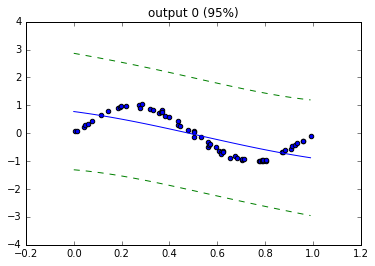

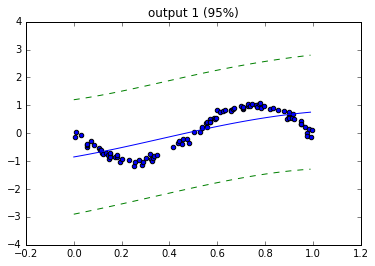

In [4]:
# Unoptimized
lmc = LMC(xss, yss, kernels=ks, normalize=False, metrics=True)
print_diagram(lmc)

In [5]:
lmc.optimize(optimizer=AdaDelta(
        # Force full 50 iterations with ratio = 0
        verbosity=10, decay=0.9, max_it=50, min_grad_ratio=0))

starting AdaDelta {'momentum': 0.5, 'min_grad_ratio': 0, 'max_it': 50, 'offset': 0.0001, 'decay': 0.9, 'verbosity': 10, 'step_rate': 1, 'roll': 3}
iteration        5 grad norm 2.4650e+01
iteration       10 grad norm 2.4406e+01
iteration       15 grad norm 4.1992e+01
iteration       20 grad norm 6.2885e+00
iteration       25 grad norm 2.0958e+01
iteration       30 grad norm 1.1592e+01
iteration       35 grad norm 3.0152e+00
iteration       40 grad norm 4.7907e+00
iteration       45 grad norm 5.9846e+00
iteration       50 grad norm 9.3531e+00
finished adadelta optimization
            50 iterations
    9.3531e+00 final grad norm
    9.0914e+00 final MA(3) grad norm
    4.0689e+01 max MA(3) grad norm
    norm used inf


In [6]:
def moving_average(a, n) :
    sums = np.add.accumulate(a, dtype=float)
    sums[n:] = sums[n:] - sums[:-n]
    sums[n:] /= n
    sums[:n] /= np.arange(1, n + 1)
    return sums

def div_rolled_max(a, n):
    ma = moving_average(a, n)
    roll_max = np.maximum.accumulate(ma)
    return ma / roll_max * roll_max[-1]

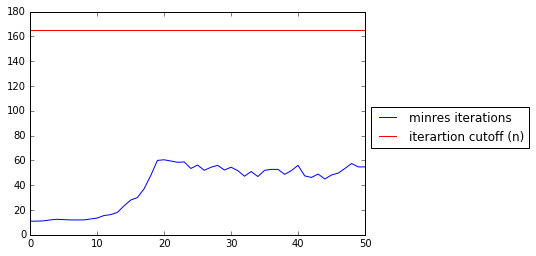

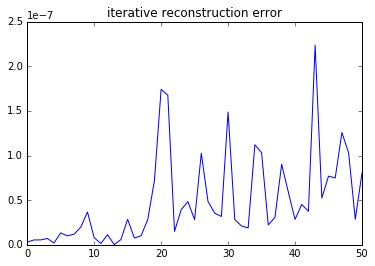

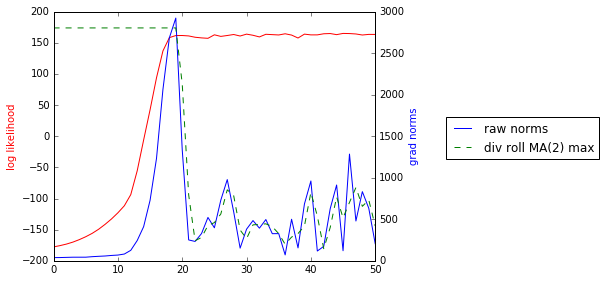

In [7]:
# x axis is optimization iteration on all graphs
plt.plot(lmc.metrics.iterations, label='minres iterations')
plt.axhline(sum(n_per_output), label='iterartion cutoff (n)', c='r')
plt.legend(bbox_to_anchor=(1, 0.6), loc=2)
plt.show()
plt.plot(lmc.metrics.solv_error)
plt.title('iterative reconstruction error')
plt.show()

fig, ax1 = plt.subplots()
ax1.plot(lmc.metrics.log_likely, c='r')
ax1.set_ylabel('log likelihood', color='r')
ax2 = ax1.twinx()
ax2.plot(lmc.metrics.grad_norms, c='b', label='raw norms')
n=2
ax2.plot(div_rolled_max(lmc.metrics.grad_norms, n), c='g', ls='--', 
         label='div roll MA({}) max'.format(n))
ax2.set_ylabel('grad norms', color='b')
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.2, 0.6), loc=2)
plt.show()


Name : lmc
Objective : -163.77804059462613
Number of Parameters : 12
Number of Optimization Parameters : 12
Updates : True
Parameters:
  lmc.                  |          value  |  constraints  |  priors
  rbf0.inv_lengthscale  |   2.8733093706  |      +ve      |        
  rbf1.inv_lengthscale  |  5.75107478419  |      +ve      |        
  a0                    |         (1, 2)  |               |        
  a1                    |         (1, 2)  |               |        
  kappa0                |           (2,)  |      +ve      |        
  kappa1                |           (2,)  |      +ve      |        
  noise                 |           (2,)  |      +ve      |        
  index  |     lmc.noise  |  constraints  |  priors
  [0]    |    0.00253720  |      +ve      |        
  [1]    |    0.00800440  |      +ve      |        


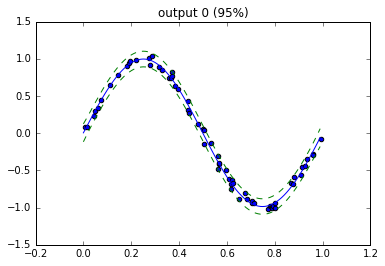

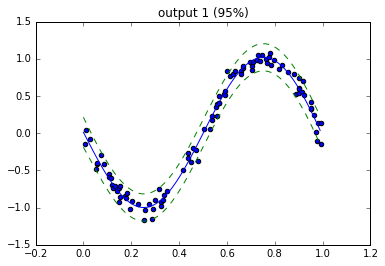

In [8]:
#optimized
print(lmc)
print(lmc.noise)
print_diagram(lmc)

In [9]:
import GPy

rbfs = [GPy.kern.RBF(1) for _ in range(nout)]
# not exactly the same since mine is rank-1 only for now
# This is why we need as many kernels as outputs, because we'd be rank-deficient o/w
k = GPy.util.multioutput.LCM(input_dim=1,num_outputs=nout,kernels_list=rbfs)
xss_reshaped = [xs.reshape(-1, 1) for xs in xss]
yss_reshaped = [ys.reshape(-1, 1) for ys in yss]
m = GPy.models.GPCoregionalizedRegression(
    xss_reshaped, yss_reshaped, kernel=k)
m.optimize()
print(m)


Name : gp
Objective : -180.1539850138177
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  gp.                                    |              value  |  constraints  |  priors
  sum.ICM0.rbf.variance                  |   0.00378978936181  |      +ve      |        
  sum.ICM0.rbf.lengthscale               |     0.339653291716  |      +ve      |        
  sum.ICM0.B.W                           |             (2, 1)  |               |        
  sum.ICM0.B.kappa                       |               (2,)  |      +ve      |        
  sum.ICM1.rbf.variance                  |  3.10702486148e-09  |      +ve      |        
  sum.ICM1.rbf.lengthscale               |      8.88957710298  |      +ve      |        
  sum.ICM1.B.W                           |             (2, 1)  |               |        
  sum.ICM1.B.kappa                       |               (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   0.00250679472731  | 

 /usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


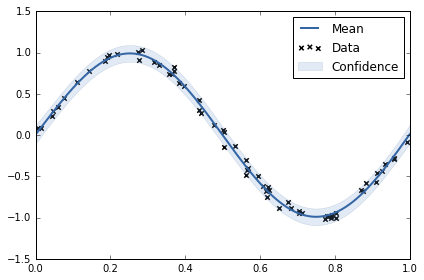

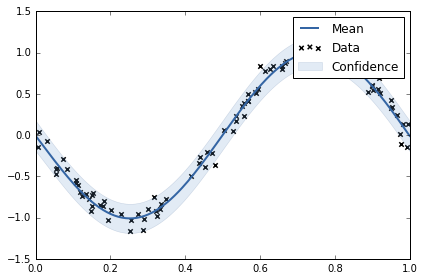

In [10]:
# Plotting code adapted from GPy coregionalization tutorial
# Also 95% confidence

data_rows = np.add.accumulate(n_per_output)
data_rows = np.insert(data_rows, 0, 0)

for i in range(nout):
    m.plot(
        plot_limits=(0, 1),
        fixed_inputs=[(1,i)],
        which_data_rows=slice(data_rows[i],data_rows[i + 1]))